#### Handwritten Digit Recognization is one of the oldest problem of Machine Learning and is used to baseline performance of new algorithm.

#### I will share my way of addressing this challenge starting from applying Classification algorithms, PCA, Neural Network and ultimately CNN.

#### There is ample scope to improve this Notebook but I am sure the small footsteps outlined here will be helpful to solidify our learning.

#### Import the basic libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
%matplotlib inline

#### Load the train data.

In [2]:
train_data = pd.read_csv("../input/digit-recognizer/train.csv")

#### Explore train data.

In [3]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### The 'label' is the target column and it says whether the values of pixel0 to pixel784 make it to any digit from 0 to 9.

#### Each pixel has value in the range of 0 to 255.

In [4]:
train_data.shape

(42000, 785)

#### Separate out predictor variables i.e pixel values and label.

In [5]:
model_train_data_unscaled = train_data.drop(['label'], axis=1)
model_train_label = train_data['label']

#### Let's visualize one row of the train dataset.

8


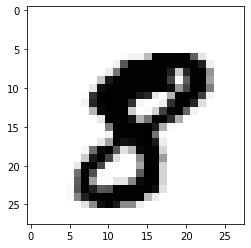

In [6]:
plt.imshow(np.array(model_train_data_unscaled.loc[10]).reshape(28, 28), cmap='Greys')
print(model_train_label[10])

#### There is no missing value and there is very little scope of feature engineering; so we will only do scaling of pixel values to bring them within 0 and 1.

In [7]:
from sklearn.preprocessing import MinMaxScaler

std_scaler = MinMaxScaler()
model_train_data = std_scaler.fit_transform(model_train_data_unscaled.astype(np.float64))

#### We will create a standard function so that we can have similar metrics displayed for different algorithms.

In [8]:
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve

def model_def(model, model_name, m_train_data, m_train_label):
    model.fit(m_train_data, m_train_label)
    s = "predict_"
    p = s + model_name
    p = model.predict(m_train_data)
    cm = confusion_matrix(m_train_label, p)
    precision = np.diag(cm)/np.sum(cm, axis=0)
    recall    = np.diag(cm)/np.sum(cm, axis=1)
    F1 = 2 * np.mean(precision) * np.mean(recall)/(np.mean(precision) + np.mean(recall))
    cv_score = cross_val_score(model, m_train_data, m_train_label, cv=3, scoring='accuracy')
    print("Precision Is      :", np.mean(precision))
    print("Recall Is         :", np.mean(recall))
    print("F1 Score IS       :", F1)
    print("Mean CV Score     :", cv_score.mean())
    print("Std Dev CV Score  :", cv_score.std())

#### Let's start applying different algorithm on the train dataset.

#### Softmax Regression.

In [9]:
from sklearn.linear_model import LogisticRegression

softmax = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial', C=0.05)
model_def(softmax, "softmax", model_train_data, model_train_label)

Precision Is      : 0.9285167036162614
Recall Is         : 0.9283923949551989
F1 Score IS       : 0.9284545451248793
Mean CV Score     : 0.917404761904762
Std Dev CV Score  : 0.0005899767473030273


#### Now we will apply PCA and which is one of the main dimensionality reduction technique. PCA stands for Principal Component Analysis and here the columns across which the data has maximum variability are retained; so we can drop few columns without losing significant amount of insights.

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 200)
model_train_data2D = pca.fit_transform(model_train_data)
print("Explained Variance Ratio:", np.sum(pca.explained_variance_ratio_))

Explained Variance Ratio: 0.9661605279836099


#### So you can see if we use only 200 columns out of 784 columns we are able to explain 96.61% variability of the data.

#### We will use this updated dataset on Polynomial Kernel Classification.

In [11]:
from sklearn.svm import SVC

poly6 = SVC(C=2, kernel='poly', degree=3, gamma='auto', random_state=42)
model_def(poly6, "poly6", model_train_data2D, model_train_label)

Precision Is      : 0.9468095193993629
Recall Is         : 0.9456733197372247
F1 Score IS       : 0.9462410784952744
Mean CV Score     : 0.9238333333333334
Std Dev CV Score  : 0.0029331168751303652


#### We can see a slight improvement in model performance.

#### Now we will apply ANN to solve the challenge. Since we want to use the standard function to display model metrics like CV score we need to build an wrapper.

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [13]:
def build_classifier():
    classifier = Sequential([Dense(128, kernel_initializer='random_uniform', activation='relu', input_shape=(200,)),
                             Dropout(rate=0.2),
                             Dense(128, kernel_initializer='random_uniform', activation='relu'),
                             Dropout(rate=0.2),
                             Dense(10, kernel_initializer='random_uniform', activation='softmax')])
    classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return classifier

ANN_classifier = KerasClassifier(build_fn=build_classifier, batch_size=100, epochs=20)
ANN_classifier.fit(model_train_data2D, model_train_label)

Epoch 1/20
42000/42000 [==============================] - 2s 54us/step - loss: 0.5489 - accuracy: 0.8589
Epoch 2/20
42000/42000 [==============================] - 1s 29us/step - loss: 0.1958 - accuracy: 0.9405
Epoch 3/20
42000/42000 [==============================] - 1s 29us/step - loss: 0.1458 - accuracy: 0.9565
Epoch 4/20
42000/42000 [==============================] - 1s 30us/step - loss: 0.1168 - accuracy: 0.9640
Epoch 5/20
42000/42000 [==============================] - 1s 30us/step - loss: 0.0990 - accuracy: 0.9691
Epoch 6/20
42000/42000 [==============================] - 1s 32us/step - loss: 0.0833 - accuracy: 0.9744
Epoch 7/20
42000/42000 [==============================] - 1s 30us/step - loss: 0.0732 - accuracy: 0.9761
Epoch 8/20
42000/42000 [==============================] - 1s 30us/step - loss: 0.0674 - accuracy: 0.9787
Epoch 9/20
42000/42000 [==============================] - 1s 31us/step - loss: 0.0611 - accuracy: 0.9813
Epoch 10/20
42000/42000 [==============================

In [14]:
cv_score = cross_val_score(ANN_classifier, model_train_data2D, model_train_label, cv=5, scoring='accuracy')
print("Mean CV Score Is:", cv_score.mean())

Epoch 1/20
33600/33600 [==============================] - 1s 36us/step - loss: 0.6172 - accuracy: 0.8433
Epoch 2/20
33600/33600 [==============================] - 1s 30us/step - loss: 0.2121 - accuracy: 0.9354
Epoch 3/20
33600/33600 [==============================] - 1s 31us/step - loss: 0.1611 - accuracy: 0.9509
Epoch 4/20
33600/33600 [==============================] - 1s 31us/step - loss: 0.1263 - accuracy: 0.9612
Epoch 5/20
33600/33600 [==============================] - 1s 30us/step - loss: 0.1044 - accuracy: 0.9676
Epoch 6/20
33600/33600 [==============================] - 1s 31us/step - loss: 0.0909 - accuracy: 0.9714
Epoch 7/20
33600/33600 [==============================] - 1s 30us/step - loss: 0.0775 - accuracy: 0.9752
Epoch 8/20
33600/33600 [==============================] - 1s 30us/step - loss: 0.0689 - accuracy: 0.9786
Epoch 9/20
33600/33600 [==============================] - 1s 33us/step - loss: 0.0597 - accuracy: 0.9810
Epoch 10/20
33600/33600 [==============================

33600/33600 [==============================] - 1s 37us/step - loss: 0.0293 - accuracy: 0.9896
Epoch 19/20
33600/33600 [==============================] - 1s 32us/step - loss: 0.0301 - accuracy: 0.9901
Epoch 20/20
33600/33600 [==============================] - 1s 31us/step - loss: 0.0275 - accuracy: 0.9906
Epoch 1/20
33600/33600 [==============================] - 1s 36us/step - loss: 0.6269 - accuracy: 0.8282
Epoch 2/20
33600/33600 [==============================] - 1s 31us/step - loss: 0.2254 - accuracy: 0.9324
Epoch 3/20
33600/33600 [==============================] - 1s 31us/step - loss: 0.1628 - accuracy: 0.9517
Epoch 4/20
33600/33600 [==============================] - 1s 31us/step - loss: 0.1344 - accuracy: 0.9600
Epoch 5/20
33600/33600 [==============================] - 1s 30us/step - loss: 0.1100 - accuracy: 0.9662
Epoch 6/20
33600/33600 [==============================] - 1s 31us/step - loss: 0.0942 - accuracy: 0.9712
Epoch 7/20
33600/33600 [==============================] - 1s 31u

In [15]:
print("Mean CV Score Is:", cv_score.mean())

Mean CV Score Is: 0.9734285714285715


#### So we can see a significant improvement in accuracy using an ANN to classify.

#### Now we will use test data to predict.

In [16]:
test_data = pd.read_csv("../input/digit-recognizer/test.csv")

model_test_data = std_scaler.transform(test_data.astype(np.float64))
model_test_data2D = pca.transform(model_test_data)

In [17]:
predict_test_poly6 = poly6.predict(model_test_data2D)

In [18]:
predict_test_softmax = softmax.predict(model_test_data)
predict_test_ANN = ANN_classifier.predict(model_test_data2D)

Id = DataFrame(np.arange(1,28001))
Id.columns = ['ImageId']

prediction = DataFrame(predict_test_poly6)
prediction.columns = ['Label']

result = pd.concat([Id, prediction], axis=1)
result.to_csv("Submission_Poly.csv", index=False)

Id = DataFrame(np.arange(1,28001))
Id.columns = ['ImageId']

prediction = DataFrame(predict_test_softmax)
prediction.columns = ['Label']

result = pd.concat([Id, prediction], axis=1)
result.to_csv("Submission_Softmax.csv", index=False)

Id = DataFrame(np.arange(1,28001))
Id.columns = ['ImageId']

prediction = DataFrame(predict_test_ANN)
prediction.columns = ['Label']

result = pd.concat([Id, prediction], axis=1)
result.to_csv("Submission_ANN.csv", index=False)

#### Now we will apply Convolutional Neural Network(CNN) techniques on the original data.

In [19]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Dropout

#### Reshaping the data to the format Convolution layer expects.

#### Input shape - 4D tensor with shape: (batch_size, channels, rows, cols) if data_format='channels_first' or 4D tensor with shape: (batch_size, rows, cols, channels) if data_format='channels_last'.

In [20]:
X_train = np.array(model_train_data_unscaled).reshape(42000, 28, 28, 1)
y_train = model_train_label
X_test = np.array(test_data).reshape(28000, 28, 28, 1)

In [21]:
CNN_model = Sequential([Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), input_shape=(28,28,1),
                            padding='valid', activation='relu'),
                         MaxPooling2D(pool_size=(2, 2)),
                         Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1),
                            padding='valid', activation='relu'),
                         MaxPooling2D(pool_size=(2, 2)),
                         Flatten(),
                         Dense(128, kernel_initializer='random_uniform', activation='relu'),
                         Dropout(rate=0.2),
                         Dense(128, kernel_initializer='random_uniform', activation='relu'),
                         Dropout(rate=0.2),
                         Dense(10, kernel_initializer='random_uniform', activation='softmax')])

CNN_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

CNN_model.fit(X_train, y_train, batch_size=100, epochs=20)

Epoch 1/20
42000/42000 [==============================] - 5s 126us/step - loss: 0.2263 - accuracy: 0.9293
Epoch 2/20
42000/42000 [==============================] - 2s 58us/step - loss: 0.0720 - accuracy: 0.9790
Epoch 3/20
42000/42000 [==============================] - 2s 53us/step - loss: 0.0514 - accuracy: 0.9850
Epoch 4/20
42000/42000 [==============================] - 2s 52us/step - loss: 0.0443 - accuracy: 0.9873
Epoch 5/20
42000/42000 [==============================] - 2s 56us/step - loss: 0.0375 - accuracy: 0.9885
Epoch 6/20
42000/42000 [==============================] - 3s 62us/step - loss: 0.0338 - accuracy: 0.9905
Epoch 7/20
42000/42000 [==============================] - 2s 59us/step - loss: 0.0298 - accuracy: 0.9908
Epoch 8/20
42000/42000 [==============================] - 2s 53us/step - loss: 0.0280 - accuracy: 0.9911
Epoch 9/20
42000/42000 [==============================] - 2s 58us/step - loss: 0.0256 - accuracy: 0.9922
Epoch 10/20
42000/42000 [=============================

In [22]:
y_test = CNN_model.predict(X_test)
y_test.shape

(28000, 10)

2


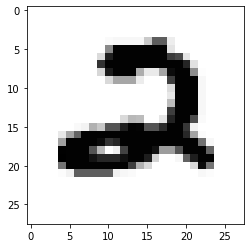

In [23]:
predict_test_CNN = np.argmax(y_test, axis=1)
plt.imshow(np.array(test_data.loc[0]).reshape(28, 28), cmap='Greys')
print(predict_test_CNN[0])

In [24]:
Id = DataFrame(np.arange(1,28001))
Id.columns = ['ImageId']

prediction = DataFrame(predict_test_CNN)
prediction.columns = ['Label']

result = pd.concat([Id, prediction], axis=1)
result.to_csv("Submission_CNN.csv", index=False)